In [3]:
import numpy as np
import matplotlib.pyplot as plt

from DriveCalc import *

In [2]:
motor_table = get_motor_database()

In [3]:
for col in motor_table.columns:
            print(col)

myid
tbs
Name
Rem
custom
meas
match
StatDia
StatH
Turns
WireDia
Delta
Imax
Weight
mgear_id
mesc_id
kV
Rm
K
MvK
kL
ts


In [4]:
class MotorGeneric():
    """
    This class describes an electric motor chaaracterized by
    the generator voltage coefficient, the effective winding resistance
    and the no-load power.
    """
    
    def __init__(self, kV, Ri, I0):
        """
        Generate a generic electric motor.
        """
        self.Name = 'generic'
        print(self.Name)
        self.kV = kV
        self.Ri = Ri
        self.I0 = I0

    def noLoadRPM(self, U):
        """
        Compute the RPM at no load at given voltage.
        """
        return U*self.kV
    
    def shaftPowerFromRPM(self, rpm, U):
        """
        Given the battery voltage, the shaft power output is computed
        from the revolution speed (max noLoadRPM)
        """
        if rpm < self.noLoadRPM(U):
            U_wirk = U - rpm/self.kV
            I_wirk = U_wirk/self.Ri
            return U_wirk*I_wirk
        else:
            return 0.0

    def currentFromRPM(self, rpm, U):
        """
        Given the battery voltage, the current consumption is computed
        from the revolution speed (max noLoadRPM)
        """
        if rpm < self.noLoadRPM(U):
            U_wirk = U - rpm/self.kV
            return U_wirk/self.Ri + self.I0
        else:
            return 0.0

In [5]:
mot = MotorGeneric(1500,0.2,1.0)

generic


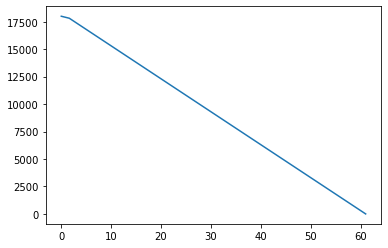

In [6]:
rpmList = np.linspace(0,mot.noLoadRPM(12.0),100)
iList = [mot.currentFromRPM(rpm,12.0) for rpm in rpmList]

plt.plot(iList,rpmList)
plt.show()

## T-Motor MN2806 650kV with P13x4.4

In [60]:
mn2860 = MotorGeneric(600, 1.3*0.275, 0.2)

generic


In [61]:
vList=[15.51, 15.51, 15.43, 15.42, 15.39, 15.37, 15.33, 15.33, 15.28, 15.25, 15.22, 15.19, 15.17]
pwmList=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75,0.8, 0.85, 0.9, 0.95, 1.0]
iBattList=[1.32, 1.88, 2.48, 3.13, 3.88, 4.64, 5.46, 6.49, 7.59, 8.77, 10.1, 11.29, 12.28]
print(np.array(iBattList)*np.array(vList))
veffList = np.array(vList) * np.array(pwmList)
print(veffList)
rpmList=[2994, 3371, 3694, 3989, 4278, 4538, 4777, 5041, 5284, 5510, 5729, 5925, 6061]
pList=[20.44, 29.13, 38.3, 48.2, 59.7, 71.4, 83.7, 99.5, 116.0, 133.7, 152.4, 171.6, 186.4]
iList = np.array(pList)/np.array(veffList)
print(iList)

[ 20.4732  29.1588  38.2664  48.2646  59.7132  71.3168  83.7018  99.4917
 115.9752 133.7425 153.722  171.4951 186.2876]
[ 6.204   6.9795  7.715   8.481   9.234   9.9905 10.731  11.4975 12.224
 12.9625 13.698  14.4305 15.17  ]
[ 3.29464861  4.17365141  4.96435515  5.68329206  6.46523717  7.14678945
  7.79983226  8.65405523  9.4895288  10.31436837 11.12571178 11.89147985
 12.28740936]


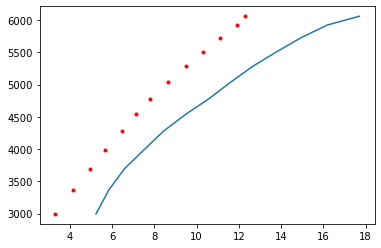

In [59]:
i = [mn2860.currentFromRPM(r,v) for (r,v) in zip(rpmList,veffList)]

plt.plot(i,rpmList)
plt.plot(iList,rpmList,'r.')
plt.show()

[ 12.54123787  21.18061767  27.07843428  33.41816825  40.31920012
  52.27400736  55.02708972  68.62599712  77.46748605  86.55087761
  95.99031633 111.68361884 114.24715844]


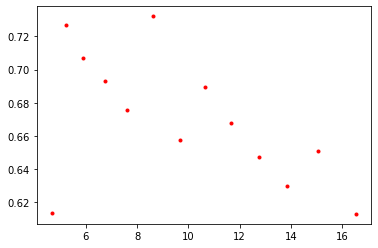

In [49]:
# measured shaft torque [Nm]
qList=[0.04, 0.06, 0.07, 0.08, 0.09, 0.11, 0.11, 0.13, 0.14, 0.15, 0.16, 0.18, 0.18]
pShaftList= np.array(qList)*np.array(rpmList)*2*np.pi/60.0
print(pShaftList)

eta = pShaftList / np.array(pList)
plt.plot(i,eta,'r.')
plt.show()

In [50]:
# fit torque constant kA [Nm/A]
kA = qList[-1] / iList[-1]
print(kA)

0.014649141630901287


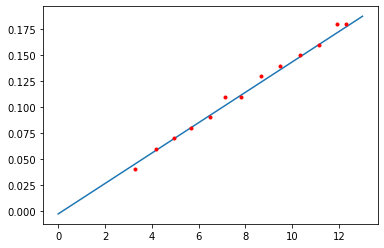

In [51]:
iPlot = np.linspace(0,13,100)
qPlot = kA*(iPlot-mn2860.I0)

plt.plot(iPlot,qPlot)
plt.plot(iList,qList,'r.')
plt.show()

In [52]:
# Thrust generated with P13x4.4
tList=[2.69, 3.46, 4.17, 4.85, 5.57, 6.26, 7.0, 7.85, 8.63, 9.41, 10.15, 10.90, 11.38]

In [53]:
p1344 = PropellerStatic()
p1344.fitThrust(rpmList, tList)

generic
a=2.15534e-07  b=2.04183
n10N=5684.783509


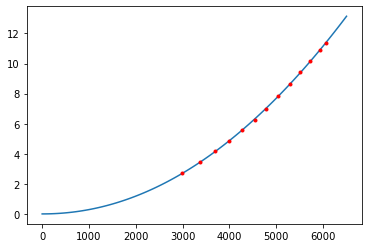

In [54]:
rpm = np.linspace(0,6500,100)
tPlot = [p1344.Thrust(r) for r in rpm]

plt.plot(rpm,tPlot)
plt.plot(rpmList,tList,'r.')
plt.show()

In [55]:
p1344.fitPower(rpmList, pShaftList)

c=3.95403e-10  d=3.03309
n100W=5747.954051


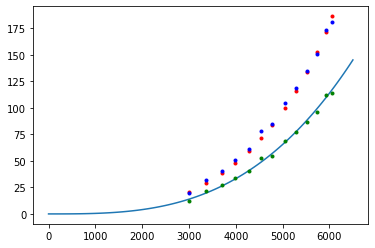

In [56]:
pPlot = [p1344.ShaftPower(r) for r in rpm]

pModel = pShaftList + iList*mn2860.Ri*veffList

plt.plot(rpm,pPlot)
plt.plot(rpmList,pList,'r.')
plt.plot(rpmList,pModel,'b.')
plt.plot(rpmList,pShaftList,'g.')
plt.show()